     pcost       dcost       gap    pres   dres
 0: -1.1936e+01 -3.3004e+01  2e+01  0e+00  2e+00
 1: -1.5375e+01 -2.2251e+01  7e+00  7e-16  7e-01
 2: -1.9317e+01 -2.6817e+01  8e+00  9e-16  6e-01
 3: -3.7778e+01 -4.7767e+01  1e+01  4e-15  4e-01
 4: -4.3247e+01 -4.4999e+01  2e+00  1e-15  4e-02
 5: -4.3773e+01 -4.3839e+01  7e-02  7e-15  9e-04
 6: -4.3818e+01 -4.3819e+01  8e-04  1e-14  9e-06
 7: -4.3818e+01 -4.3818e+01  8e-06  2e-14  9e-08
Optimal solution found.
lagrange is: 
[ 1.48428696e-08  4.46577200e+01  1.20873504e-08  2.37725791e-08
  1.81106572e-08  1.84702940e-08  1.92663231e-08  1.39919513e-08
  2.11577455e-08  1.77182303e-08  1.43286863e-08  1.51401995e-08
  1.56324725e-08  1.27071806e-08  1.40021933e-08  8.41182141e-08
  1.83593565e-08  5.06214889e-08  2.02991425e-08  1.76546802e-06
 -2.09430588e-08 -1.82219800e-07 -1.41002587e-08 -3.05933946e-07
 -2.33356728e-08 -2.25348369e-08 -1.13020725e-06 -2.43441272e-08
 -2.56537851e-08 -2.00097129e-08 -1.24470384e-04 -1.92770921e-08
 -

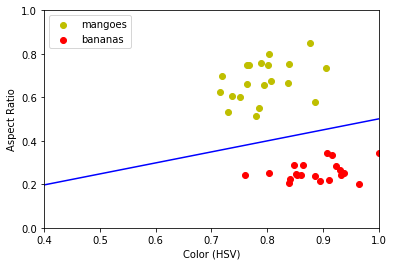

In [76]:
import numpy as np
import csv
from cvxopt import matrix, solvers
import matplotlib.pyplot as plt



#*** GETTING DATA ***
#CSV files have columns "effective eccentricity," "average hue," and the classifier "z"
#For this exercise, oranges and bananas have z = -1 and mangoes have z = 1

mangoes = []
oranges = []
bananas = []

with open('LED flash.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter = ',')
    next(readCSV)
    m_ecc = []
    m_hue = []
    m_z = []
    
    for col in readCSV:
        x = float(col[0])
        y = float(col[1])
        z = float(col[2])
        
        m_ecc.append(y)
        m_hue.append(x)
        m_z.append(z)
        
for i in range(len(m_z)):
    mangoes.append([m_ecc[i], m_hue[i]])

with open('oranges2.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter = ',')
    next(readCSV)
    o_ecc = []
    o_hue = []
    o_z = []
    
    for col in readCSV:
        x = float(col[0])
        y = float(col[1])
        z = float(col[2])
        
        o_ecc.append(y)
        o_hue.append(x)
        o_z.append(z)

for i in range(len(o_z)):
    oranges.append([o_ecc[i], o_hue[i]])

with open('bananas2.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter = ',')
    next(readCSV)
    b_ecc = []
    b_hue = []
    b_z = []
    
    for col in readCSV:
        x = float(col[0])
        y = float(col[1])
        z = float(col[2])
        
        b_ecc.append(y)
        b_hue.append(x)
        b_z.append(z)

for i in range(len(b_z)):
    bananas.append([b_ecc[i], b_hue[i]])
    

#*** CHOOSE TWO CLASSES FOR OPTIMIZED DECISION LINE ***
c1 = np.array(mangoes)
c2 = np.array(bananas)
d1 = m_z
d2 = o_z
dataset = np.concatenate((c1, c2))
zset = np.concatenate((d1,d2))


N = len(dataset)
P = np.matmul(dataset, np.transpose(dataset))

for i in range(N):
    for j in range(N):
        P[i][j] *= zset[i]*zset[j]
        if i == j:
            P[i][j] += 0.001

H = P
P = matrix(P)

q = np.ones((N, 1))
q *= -1.0
q = matrix(q)
        

G = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        if i == j:
            G[i][j] = -1.0
G=matrix(G)


h = np.zeros((N, 1))
h = matrix(h)


sol = solvers.qp(P, q, G, h)
lagrange = np.array(sol['x']).reshape((H.shape[1],))


for i in range(N):
    lagrange[i] *= zset[i]

print('lagrange is: ')
print(lagrange)
weights = np.matmul(lagrange, dataset)


i = 1 #Choose i that gives best decision line, i can be anything so long as corresponding lagrange[i] > 0
w0 = (1/zset[i]) - np.matmul(weights, dataset[i])
print('w0:',w0)

weights = np.insert(weights, 0, w0)


#*** PLOTTING ***

#Plotting decision line and classes
slope = -weights[1]/weights[2]
intercept = -weights[0]/weights[2]
print('weights:',weights)
print('slope:',slope)
print('intercept:',intercept)
u = np.linspace(0, 1, 100)
v = []
for i in range(100):
    v.append(slope*u[i] + intercept)

fig, ax = plt.subplots()
ax.scatter(c1[:,0], c1[:,1], c = "y", label="mangoes")
ax.scatter(c2[:,0], c2[:,1], c = "r", label="bananas")
ax.plot(u, v, c = "b")
plt.xlabel("Color (HSV)")
plt.ylabel("Aspect Ratio")
plt.xlim(0.4,1)
plt.ylim(0,1)
ax.legend()
plt.show()